In [2]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from keras.callbacks import TensorBoard
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import datetime
import pygame


physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    

c:\Users\robin\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\robin\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

# Proximal Policy Optimization

PPO is a policy gradient Actor-Critic algorithm. The policy model, the **actor** network  produces a stochastic policy. It maps the state to a probability distribution over the set of possible actions. The **critic** network is used to approximate the value function and then, the advantage is calculated:

$$
A_\Phi (s_t, a_t) = q_\Phi (s_t,a_t) - v_\Phi (s_t) = R_t + \gamma v_{\Phi'} (s_{t+1}) - v_\Phi (s_t)
$$

The critic, $v_\Phi$ is trained in the same manner, as the DQN model and the critic of DDPG, with TD-learning and a "frozen" and periodically updated target critic network, $v_{\Phi'}$. Instead of approximating a q-value, it approximates the value.

To train the actor, PPO uses the ratio of two policies:
- a current policy $\pi_\Theta$, that is learned currently
- a baseline policy $\pi_{\Theta´}$, an earlier version of the policy

$$
r^t (\Theta)=r_\Theta (s_t,a_t) = \frac{\pi_\Theta (a_t | s_t)}{\pi_{\Theta'} (a_t | s_t)}
$$

It is the ratio of the probabilities of selecting $a_t$ given $\pi_\Theta$ and the probability of selecting the same action with $\pi_{\Theta´}$.

When multiplied with the the approximated advantage, calculated using the critic network, it can be used as the objective function (maximize with SGA)

$$
loss_{actor} = - r_\Theta (s_t, a_t) A_\Phi (s_t, a_t)
$$

as when
- the advantage is positive, meaning, that selecting the action would increase the value, the probability of selecting this action would increase
- the advantage is negative, meaning, that selecting the action would decrease the value, the probability of selecting this action would decrease

Instead of using this directly as loss function, to stabilize the implementation by adjusting the policy optimization step size, the loss is extended in a pessimistic way:

$$
loss_{actor} = \min [r_\Theta (s_t, a_t) A_\Phi (s_t, a_t), clip(r_\Theta (s_t, a_t), 1-\epsilon, 1+\epsilon) A_\Phi (s_t, a_t)]
$$

PPO uses 2 main models. The actor network learns the stochastic policy. It maps the state to a probability distribution over the set of possible actions. The critic network learns the value function. It maps the state to a scalar.

The critic, $v_\Phi$ is trained in the same manner, as the DQN model and the critic of DDPG, with TD-learning and a "frozen" and periodically updated target critic network, $v_{\Phi'}$. Instead of approximating a q-value, it approximates the value.

To train the actor, PPO uses the ratio of two policies:
- a current policy $\pi_\Theta$, that is learned currently
- a baseline policy $\pi_{\Theta´}$, an earlier version of the policy

$$
r^t (\Theta)=r_\Theta (s_t,a_t) = \frac{\pi_\Theta (a_t | s_t)}{\pi_{\Theta'} (a_t | s_t)}
$$

It is the ratio of the probabilities of selecting $a_t$ given $\pi_\Theta$ and the probability of selecting the same action with $\pi_{\Theta´}$.

When multiplied with the the approximated advantage, calculated using the critic network, it can be used as the objective function (maximize with SGA)

$$
loss_{actor} = - r_\Theta (s_t, a_t) A_\Phi (s_t, a_t)
$$

as when
- the advantage is positive, meaning, that selecting the action would increase the value, the probability of selecting this action would increase
- the advantage is negative, meaning, that selecting the action would decrease the value, the probability of selecting this action would decrease

Instead of using this directly as loss function, to stabilize the implementation by adjusting the policy optimization step size, the loss is extended in a pessimistic way:

$$
loss_{actor} = \min [r_\Theta (s_t, a_t) A_\Phi (s_t, a_t), clip(r_\Theta (s_t, a_t), 1-\epsilon, 1+\epsilon) A_\Phi (s_t, a_t)]
$$

In [64]:
#change inheritance class to enable saving the models

# *************************************************MODIFIED************************************************** 
class Actor(tf.keras.Model):    # represents/ approximates the stochastic-policy (policy = weights from the nn)
    def __init__(self, units=(400, 300), n_actions=1, **kwargs):    # input = observation shape(batchsize, observation_shape) -> same as in discrete action space 
        super(Actor, self).__init__(**kwargs)
        self._layers = []
        n_outputs = n_actions*2 # one continuous output distribution contains values std and mean for gaussian 
        for i, u in enumerate(units):
            self._layers.append(tf.keras.layers.Dense(u, activation='relu'))
        self._layers.append(tf.keras.layers.Dense(n_outputs))   # output = ?? shape(batchsize, n_outputs)
        # modify output dimension to n_actions * 2 (= 1 for MountainCarCont) -> output is now std and mean of continuous gaussian distribution
        # modify output layer activation function -> use no activation/ linear activation a(x) = x to output the estimated values directly
        # if custom clipping is necessary, use tanh as output activation function to clip[-1,1]
        # in discrete action space 'softmax' exp(x) / tf.reduce_sum(exp(x)) calculates the value of each output vector in that way, the output can be interpreted as a discrete probability distribution (sum vectors = 1)
        
    # forward pass through the network
    def call(self, inputs, **kwargs):
        outputs = inputs
        for l in self._layers:
            outputs = l(outputs)
        # if last layer is reached, prepare the output to return mean and std
        mean, log_std = tf.split(outputs, 2, axis=-1)  # Split the output(Tensor shape(batchsize, n_outputs)) into 2 tensors (mean and log_std (ln!)) along the last axis(collums)
        return mean, log_std

    
class Critic(tf.keras.Model):   # evaluates choosen actions(critic) in reference to the estimated actions(target critic) -> provides feedback to the actor (optipizing the policy was better/ worser)
    def __init__(self, units=(400, 300), **kwargs):
        super(Critic, self).__init__(**kwargs)
        self._layers = []
        for i, u in enumerate(units):
            self._layers.append(tf.keras.layers.Dense(u, activation='relu'))
        self._layers.append(tf.keras.layers.Dense(1))
        
    def call(self, inputs, **kwargs):
        outputs = inputs
        for l in self._layers:
            outputs = l(outputs)
        return outputs
    
class PPOAgent:
    def __init__(self, action_space, observation_space, gamma=0.99, epsilon = 0.1):
        self.gamma = gamma
        self.epsilon = epsilon
        self.observation_shape = observation_space.shape[0]
# *************************************************MODIFIED**************************************************     
        self.action_shape = action_space.shape[0]
        self.actor = Actor(n_actions=self.action_shape)
        self.actor_old = Actor(n_actions=self.action_shape)
# ***********************************************************************************************************     

        self.critic = Critic()
        self.target_critic = Critic()
        
        self.actor_learning_rate=0.00025
        self.critic_learning_rate=0.001
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_learning_rate)
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_learning_rate)   # default = 0,001 -> hatten wir auch schon
        self._init_networks()
        
    def _init_networks(self):
        initializer = np.zeros([1, self.observation_shape])   # ergänzt zu V1 -> hatten wir aber auch schon gemacht
        self.actor(initializer)
        self.actor_old(initializer)
        
        self.critic(initializer)
        self.target_critic(initializer)
        
        self.update_frozen_nets()

 # *************************************************MODIFIED**************************************************     
    def act(self, observation):
        mean_tensor, log_std_tensor = self.actor(observation) # Actor network will output the gaussian probability distribution of actions for the given observation-state
        mean = tf.gather(mean_tensor, indices= 0, axis=1).numpy()
        std = tf.gather(tf.exp(log_std_tensor), indices= 0, axis=1).numpy()
        #print('mean', mean, 'std', std)
        action = np.random.normal(size = self.action_shape, loc = mean, scale = std)  # modify sampling method to sample random actions in respect a continous normal distribution
        #print('Choosen Action:', action)
        return action
        # in continous action space this output should be a real number (optional clipped [-1,1])
        # for mnt car = force applied on the car (clipped [-1,1]) and * power od 0.0015 -> no custom action clipping necessary
 # ***********************************************************************************************************     
   
    def get_critic_grads(self, states, rewards, next_states, dones):    # parameters are adjusted to minimize the difference between predicted values and observed returns
        with tf.GradientTape() as tape:
            next_value = self.target_critic(next_states)
            q_value = rewards + (1-dones) * self.gamma * next_value
            value = self.critic(states)
            
            advantage = q_value - value
            loss = tf.reduce_mean(tf.square(advantage))
        gradients = tape.gradient(loss, self.critic.trainable_variables)
        return gradients, loss, advantage
    
 # *************************************************MODIFIED**************************************************     
    def get_actor_grads(self, states, actions, advantage):  # parameters are updated to maximize the expected cumulative reward, incorporating feedback from the critic
        with tf.GradientTape() as tape:
            mean_current, log_std_current = self.actor(states)  # get distribution from current policy (used to sample/ explore in enviroment)
            std_current = tf.exp(log_std_current)
            
            mean_current, log_std_current = self.actor_old(states)  # get distribution from old policy (used to evaluate current policy in ratio)
            std_current = tf.exp(log_std_current)

            p_current = tf.gather(self.actor(states), actions, axis=1)
            p_old = tf.gather(self.actor_old(states), actions, axis=1)
            ratio = p_current / p_old
# ***********************************************************************************************************     

            clip_ratio = tf.clip_by_value(ratio, 1-self.epsilon, 1+self.epsilon)
            # entropy loss hatten wir probiert, bringt aber wenig --> sollte eigentlich exploration förndern
            # standardize advantage
            advantage = (advantage - tf.reduce_mean(advantage)) / (tf.keras.backend.std(advantage) + 1e-8)
            objective = ratio * advantage
            clip_objective = clip_ratio * advantage
            loss = -tf.reduce_mean(tf.where(objective < clip_objective, objective, clip_objective))
        gradients = tape.gradient(loss, self.actor.trainable_variables)
        return gradients, loss
        

    def learn(self, states, actions, rewards, next_states, dones):
        critic_grads, critic_loss, advantage = self.get_critic_grads(states, rewards, next_states, dones)
        actor_grads, actor_loss = self.get_actor_grads(states, actions, advantage)
        
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        return actor_loss, critic_loss
    
    def update_frozen_nets(self):
        # TODO: set discount factor  -> not necessary
        weights = self.actor.get_weights()
        self.actor_old.set_weights(weights)
        
        weights = self.critic.get_weights()
        self.target_critic.set_weights(weights)

    def save_models(self, actor_path='actor_weights.h5', critic_path='critic_weights.h5'):
        self.actor.save_weights(actor_path)
        self.critic.save_weights(critic_path)

    def load_models(self, actor_path='actor_weights.h5', critic_path='critic_weights.h5'):
        try:
            self.actor.load_weights(actor_path)
            self.critic.load_weights(critic_path)
            print('Model loaded sucessful')
        except Exception as e:
            print(f"Error: {e}")


## Training

PPO is an on-policy method. We allways complete a full episode, record the trajectory and the rewards. We then use these to update our network. 

In [3]:
def compute_avg_return(env, agent, num_episodes=1, max_steps=1000, render=False):
    total_return = 0.0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_return = 0.0
        done = False
        steps = 0
        while not (done or steps > max_steps):
            if render:
                clear_output(wait=True)
                plt.axis('off')
                plt.imshow(env.render())
                plt.show()
            action = agent.act(np.array([obs]))
            obs, r, termination, truncation, _ = env.step(action)
            if termination or truncation:
                done = True
            episode_return += r
            steps += 1
        total_return += episode_return
        #print('episode_return', episode_return)
    return total_return / num_episodes

## Add a Connection to Tensorboard -> online visualization

In [4]:
# refers to log data and model data -> below for model data
jetzt = datetime.datetime.now()
datum_uhrzeit = jetzt.strftime("%Y%m%d_%H%M%S")
savedir = f'model\\default_MountainCar_{datum_uhrzeit}'
os.makedirs('model', exist_ok=True)
os.makedirs(savedir, exist_ok=True)


In [5]:
log_dir = f"{savedir}\\log"
os.makedirs(log_dir, exist_ok=True)

if os.path.exists(log_dir):
    print(f"The directory {log_dir} exists.")
    absolute_path = os.path.abspath(log_dir)
    print(absolute_path)
else:
    print(f"The directory {log_dir} does not exist.")
summary_writer = tf.summary.create_file_writer(log_dir)

# define all metrics to log
def log_metrics(epoch, total_timesteps, critic_loss, actor_loss, episode_return, actor_learning_rate, critic_learning_rate, epsilon, gamma):
    with summary_writer.as_default():
        tf.summary.scalar('epoch', epoch, step=epoch)
        tf.summary.scalar('total_timesteps', total_timesteps, step=epoch)
        tf.summary.scalar('critic_loss', critic_loss, step=epoch)
        tf.summary.scalar('actor_loss', actor_loss, step=epoch)
        tf.summary.scalar('episode_return', episode_return, step=epoch)
        tf.summary.scalar('critic_learning_rate', critic_learning_rate, step=epoch)
        tf.summary.scalar('actor_learning_rate', actor_learning_rate, step=epoch)
        tf.summary.scalar('discount_factor_gamma', gamma, step=epoch)
        tf.summary.scalar('clip_range_epsilon', epsilon, step=epoch)

# tensorboard --logdir log in bash to open the online editor

The directory model\default_MountainCar_20240103_222230\log exists.
c:\#_FESTPLATTE\06_Studium\Master_HKA\Semesterdateien\Semester 1\Roboterprogrammierung-Hein\Projekt\Coding\model\default_MountainCar_20240103_222230\log


In [65]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')  #human fur pygame gui -> very laggy!

agent = PPOAgent(env.action_space, env.observation_space)   # observation_space entpacken für obserbation_shape (siehe __init__)

In [67]:
n_rollouts = 5
batch_size = 8
learn_steps = 16
total_timesteps = 0

for i in range(150):    # one epoch -> one complete learning iteration bzw. one update of the frozen nets
    obs, _ = env.reset()
    done = False
    
    states = []
    rewards = []
    actions = []
    next_states = []
    dones = []
    
    # collect experience in the enviroment with current policy for n episodes/ rollouts
    # give the agent more time to collect experiences more apart from the starting state
    for _ in range(n_rollouts):         
        while not done:
            env.render()    # call gui if render_mode = 'human'
            action = agent.act(np.array([obs]))
            new_obs, r, termination, truncation, _ = env.step(action)
            if termination or truncation:
                done = True

            states.append(obs)
            rewards.append([r])
            actions.append([action])
            obs = new_obs
            next_states.append(obs)
            dones.append([done])

            total_timesteps += 1
    
    # store colledted experience for all rollouts/ episodes and reset enviroment for next episode/ rollout
    states, actions, rewards, next_states, dones = map(np.array, [states, actions, rewards, next_states, dones])
    obs, _ = env.reset()
    print('collected experience in n rollouts finished')

    # learn policy and value from the collected data 
    for _ in range(learn_steps):
        indices = np.arange(states.shape[0])
        np.random.shuffle(indices)  # create random indice row
        
        # switch indices to random experience distribution
        shuffled_states = states[indices]
        shuffled_actions = actions[indices]
        shuffled_rewards = rewards[indices]
        shuffled_next_states = next_states[indices]
        shuffled_dones = dones[indices]

        # divides the whole shuffled experience into batches of batch_size
        for j in range(0, states.shape[0], batch_size):
            states_batch = shuffled_states[j:j + batch_size]    # j:j + batch_size -> returns all elements from x*batch_size to (x+1)*batch_size
            actions_batch = shuffled_actions[j:j + batch_size]
            rewards_batch = shuffled_rewards[j:j + batch_size]
            next_states_batch = shuffled_next_states[j:j + batch_size]
            dones_batch = shuffled_dones[j:j + batch_size]
            
            print('try to call learn method with shuffled data')
            # push one batch of the shuffled experience to the learning method -> one update of the current nets (actor and critic) per passed batch of experience
            actor_loss, critic_loss = agent.learn(states_batch,
                                                  actions_batch,
                                                  rewards_batch,
                                                  next_states_batch,
                                                  dones_batch)
            print('update online nets, learn from one batch finished')
    agent.update_frozen_nets()
    print('update frozen nets, do one learn step finished')
    one_episode_return = compute_avg_return(env, agent, num_episodes=1)

    # Log metrics at the end of each epoch
    log_metrics(epoch = i, total_timesteps = total_timesteps,
                critic_loss = critic_loss, actor_loss= actor_loss,
                episode_return = one_episode_return,
                actor_learning_rate = agent.actor_learning_rate, critic_learning_rate = agent.critic_learning_rate,
                epsilon = agent.epsilon, gamma = agent.gamma)
    
    # do prints every 10 epochs
    if (i + 1) % 10 == 0:
        avg_return = compute_avg_return(env, agent, num_episodes=1)
        print(f'epoch {i + 1}, total_timesteps {total_timesteps}, actor loss {actor_loss}, critic loss {critic_loss}, avg_return {avg_return}')
    
env.close() # kill gui

collected experience in n rollouts finished
try to call learn method with shuffled data


InvalidArgumentError: Value for attr 'Tindices' of double is not in the list of allowed values: int16, int32, int64
	; NodeDef: {{node GatherV2}}; Op<name=GatherV2; signature=params:Tparams, indices:Tindices, axis:Taxis -> output:Tparams; attr=batch_dims:int,default=0; attr=Tparams:type; attr=Tindices:type,allowed=[DT_INT16, DT_INT32, DT_INT64]; attr=Taxis:type,allowed=[DT_INT32, DT_INT64]> [Op:GatherV2]

# Storing and loading models

In [8]:
# save the model to h5 format
#filepath_actor = f"model/default_CartPole_{datum_uhrzeit}/actor.h5"
filepath_actor = f"{savedir}\\actor.h5"

#filepath_critic = f"model/default_CartPole_{datum_uhrzeit}/critic.h5"
filepath_critic = f"{savedir}\\critic.h5"

agent.save_models(filepath_actor, filepath_critic)

In [9]:
# load the model from h5 format -> use new agent in new instance of the enviroment to prevent overwriting
load_env = gym.make("MountainCar-v0", render_mode='rgb_array')

load_agent = PPOAgent(env.action_space, env.observation_space)
load_agent._init_networks()

filepath_actor = f"model/default_CartPole_{datum_uhrzeit}_actor.h5"
filepath_critic = f"model/default_CartPole_{datum_uhrzeit}_critic.h5"

load_agent.load_models(filepath_actor, filepath_critic)

Error: [Errno 2] Unable to open file (unable to open file: name = 'model/default_CartPole_20240103_222230_actor.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


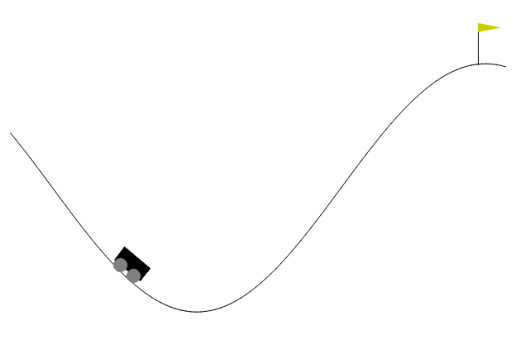

In [16]:
compute_avg_return(env, agent, num_episodes=20, render=True)
env.close()